### Stimulus encoding using MI estimator

In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

from   GDa.session           import session_info, session
from   GDa.util              import create_stages_time_grid
from   GDa.net.util          import compute_coherence_thresholds
from   GDa.temporal_network  import temporal_network
from   GDa.stats.bursting    import *

from   xfrites.conn.conn_coh import conn_coherence_wav
from   xfrites.conn.conn_tf  import wavelet_spec

from   mne.viz               import circular_layout, \
                                    plot_connectivity_circle

import matplotlib.pyplot     as     plt
import matplotlib
import GDa.graphics.plot     as     plot

import numpy             as np
import xarray            as xr
import matplotlib.pyplot as plt
import h5py
import scipy
from   tqdm              import tqdm

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [3]:
# Create directory to save figures
if not os.path.exists("img/n6.0.3"):
    os.makedirs("img/n6.0.3")

In [4]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    return np.array(x_s), np.array(x_t)

#### Load session and filter for ODRT trials with correct response

In [5]:
stages      = ['baseline', 'cue', 'delay', 'match']
band_names  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'high-$\beta$ ', r'$\gamma$' ]

In [6]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

In [7]:
# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1])

#### Compute spectra for the data

In [190]:
# Smoothing windows
sm_times  = 0.5
sm_freqs  = 1
sm_kernel = "square"

# Defining parameters
delta = 15       # Downsampling factor
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
#  mode  = 'multitaper' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])

n_freqs  = 50
freqs    = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles = freqs/2

In [191]:
sxx = wavelet_spec(data, freqs=freqs, roi=data.roi, times="time", sfreq=data.attrs["fsample"],
                 foi=foi, sm_times=sm_times, sm_freqs=sm_freqs, sm_kernel=sm_kernel, mode=mode, 
                 n_cycles=n_cycles, mt_bandwidth=None, decim=delta, kw_cwt={}, 
                 kw_mt={}, block_size=1, n_jobs=20, verbose=None)

Compute auto- and cross-spectra (n_freqs=50, decim=15, sm_times=33, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   19.6s remaining:    4.4s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   22.6s finished


#### Get stage mask for this session

In [230]:
s_mask = create_stages_time_grid(sxx.attrs["t_cue_on"], sxx.attrs["t_cue_off"],
                        sxx.attrs["t_match_on"], sxx.attrs["fsample"],
                        sxx.times.values, sxx.sizes["trials"], flatten=False)

#### Get average power per task stage

In [231]:
tmp = []
for i, s in enumerate(stages):
    tmp += [(sxx*s_mask[s][:,None,None,:]).sum(dim="times")/s_mask[s][:,None,None,:].sum(-1)]

In [232]:
tmp = xr.concat( tmp, dim="times" )
tmp.attrs = sxx.attrs
tmp = tmp.assign_coords({"times":[0,1,2,3]})

In [233]:
tmp = tmp.transpose("trials","roi","freqs","times")

In [234]:
sxx

<xarray.DataArray 'sxx' (trials: 540, roi: 49, freqs: 5, times: 244)>
array([[[[7.67185068e-08, 7.81016855e-08, 7.91425968e-08, ...,
          1.07221680e-08, 9.26985379e-09, 8.11492135e-09],
         [2.29235641e-08, 2.37500478e-08, 2.45091493e-08, ...,
          6.27795739e-09, 6.07153202e-09, 5.86387049e-09],
         [1.33460864e-08, 1.41411207e-08, 1.47952358e-08, ...,
          9.65059242e-09, 9.36008018e-09, 9.03349804e-09],
         [3.44343420e-09, 3.58518842e-09, 3.70758960e-09, ...,
          3.38520886e-09, 3.19818972e-09, 3.01068983e-09],
         [1.20912804e-09, 1.27815432e-09, 1.34604843e-09, ...,
          8.73572845e-10, 7.98465138e-10, 7.16595182e-10]],

        [[2.65420781e-08, 2.91884482e-08, 3.19637169e-08, ...,
          9.30237675e-09, 8.92136201e-09, 8.52083554e-09],
         [7.33645305e-09, 8.01646607e-09, 8.56280718e-09, ...,
          1.95049304e-08, 1.82690693e-08, 1.68172920e-08],
         [1.14900550e-08, 1.19592723e-08, 1.24444878e-08, ...,
          1.01415929e-08, 9.45656060e-09, 8.73698328e-09],
         [4.63336731e-09, 4.96539121e-09, 5.26809274e-09, ...,
          3.56964703e-09, 3.43646927e-09, 3.31297320e-09],
         [1.12979843e-09, 1.24418517e-09, 1.35983886e-09, ...,
          8.48882558e-10, 7.75460087e-10, 7.12766184e-10]],

        [[1.36587362e-08, 1.51691285e-08, 1.68739511e-08, ...,
          3.13306971e-08, 2.82830682e-08, 2.50676614e-08],
         [1.13512705e-08, 1.16605553e-08, 1.19661532e-08, ...,
          1.30597921e-08, 1.25883727e-08, 1.20085476e-08],
         [1.29472243e-08, 1.34131451e-08, 1.39188217e-08, ...,
          1.30768605e-08, 1.25655211e-08, 1.20570074e-08],
         [4.29900789e-09, 4.54860021e-09, 4.80884270e-09, ...,
          8.32695605e-09, 7.82217607e-09, 7.25042927e-09],
         [1.50052123e-09, 1.54317775e-09, 1.58603698e-09, ...,
          1.12725725e-09, 1.07271624e-09, 1.01333402e-09]],

        ...,

        [[2.26148232e-07, 2.29413301e-07, 2.32278310e-07, ...,
          2.89130216e-07, 2.73902298e-07, 2.57814067e-07],
         [1.01468708e-07, 1.03807766e-07, 1.05667982e-07, ...,
          2.64338538e-08, 2.51324708e-08, 2.37917825e-08],
         [4.14300781e-09, 4.17422110e-09, 4.21116621e-09, ...,
          2.31788379e-09, 2.17176252e-09, 2.03142262e-09],
         [1.55304100e-09, 1.59006831e-09, 1.63246971e-09, ...,
          1.58969115e-09, 1.53005742e-09, 1.47294471e-09],
         [2.33595045e-10, 2.42902863e-10, 2.52592319e-10, ...,
          3.81366160e-10, 3.59103453e-10, 3.34869728e-10]],

        [[1.04358268e-07, 1.10350592e-07, 1.16474432e-07, ...,
          2.34608692e-07, 2.25378137e-07, 2.15404183e-07],
         [1.00698541e-07, 1.03919796e-07, 1.07272303e-07, ...,
          1.61140076e-07, 1.56042949e-07, 1.50561224e-07],
         [2.51410142e-08, 2.54698561e-08, 2.57825695e-08, ...,
          6.87887720e-09, 6.53810053e-09, 6.20798320e-09],
         [3.83643816e-09, 4.00463523e-09, 4.16733497e-09, ...,
          3.49889463e-09, 3.30463835e-09, 3.08955244e-09],
         [2.42430291e-10, 2.58573739e-10, 2.75685477e-10, ...,
          4.10180998e-10, 3.72849800e-10, 3.36192938e-10]],

        [[1.55601223e-07, 1.61511534e-07, 1.65862971e-07, ...,
          8.83041967e-08, 8.37101599e-08, 8.00122945e-08],
         [3.38126548e-08, 3.98757910e-08, 4.71781501e-08, ...,
          1.95143438e-07, 1.89365741e-07, 1.82821307e-07],
         [1.01679305e-08, 1.10151479e-08, 1.19584297e-08, ...,
          4.72862232e-09, 4.43129321e-09, 4.18085007e-09],
         [2.68699196e-09, 2.79046499e-09, 2.89683995e-09, ...,
          1.84815885e-09, 1.66114529e-09, 1.47678377e-09],
         [3.59302674e-10, 3.84091443e-10, 4.07151773e-10, ...,
          5.00585605e-10, 4.82704358e-10, 4.63816798e-10]]],


       [[[3.43063534e-08, 3.56770502e-08, 3.70938553e-08, ...,
          8.48761215e-08, 8.35532385e-08, 8.20684949e-08],
         [1.06702016e-08, 1.17464695e-08, 1.29958653e-08, ...,
          1.43425645e-08, 1.31250869e-08, 1.17488500e-08]

### MI workflow

In [224]:
from frites.dataset  import SubjectEphy, DatasetEphy
from frites.workflow import WfMi

In [244]:
dt = DatasetEphy([sxx], y=[sxx.attrs["stim"].astype(int)], times="times", roi=None, agg_ch=False)

Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
WARNING | No regions of interest are provided (roi). Default ones are created
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)


In [245]:
mi_type   = 'cd'
inference = 'ffx'
kernel    = np.hanning(1)
wf        = WfMi(mi_type, inference, verbose=True, kernel=kernel)

Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cd)


In [246]:
# list of corrections for multiple comparison
mcps = ['cluster', 'maxstat', 'fdr', 'bonferroni']
kw = dict(n_jobs=20, n_perm=200)
"""
The `cluster_th` input parameter specifies how the threshold is defined.
Use either :
* a float for a manual threshold
* None and it will be infered using the distribution of permutations
* 'tfce' for a TFCE threshold
"""
cluster_th = 'tfce'  # {float, None, 'tfce'}

for mcp in mcps:
    print(f'-> FFX / MCP={mcp}')
    mi, pvalues = wf.fit(dt, mcp=mcp, cluster_th=cluster_th, **kw)
    # remove p-values that exceed 0.05
    #pvalues.data[pvalues >= .05] = 1.

    #plt.subplot(212)
    #plt.plot(pvalues.squeeze(), label=f'ffx-{mcp}')
    #plt.xlabel('Time (s)'), plt.ylabel("P-values")
    #plt.title("P-values (ffx)")
    #plt.autoscale(tight=True)
#plt.legend()

#plt.subplot(211)
#plt.plot( mi.squeeze())
#plt.xlabel('Time (s)'), plt.ylabel("Bits")
#plt.title("Mutual information I(C; D)")
#plt.autoscale(tight=True)

plt.show()

    Evaluate true and permuted mi (n_perm=200, n_jobs=20)


-> FFX / MCP=cluster


  0%|          | Estimating MI : 0/49 [00:00<?,       ?it/s]

    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=True)
    Inference at cluster-level
    Cluster detection (threshold={'start': 0.009394635446369648, 'step': 0.0011656230222433805, 'e_power': 0.5, 'h_power': 2}; tail=1)
    True and permuted mutual-information already computed. Use WfMi.clean to reset arguments
    Fixed-effect inference (FFX)
    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=maxstat; tail=1)
    True and permuted mutual-information already computed. Use WfMi.clean to reset arguments
    Fixed-effect inference (FFX)
    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=fdr; tail=1)
    True and permuted mutual-information already computed. Use WfMi.clean to reset arguments
    Fixed-effect inference (FFX)
    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=bonferroni; tail=1)


-> FFX / MCP=maxstat
-> FFX / MCP=fdr
-> FFX / MCP=bonferroni


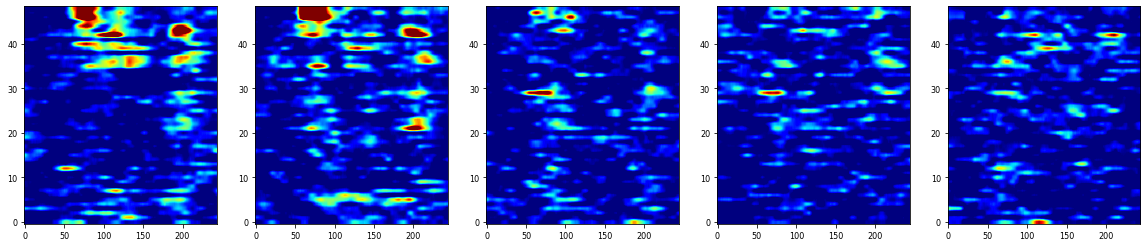

In [256]:
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    extent=[pvalues.times.values[0], mi.times.values[-1], 0,22]
    plt.imshow(mi.isel(freqs=i).T, aspect="auto", cmap="jet", origin="lower", vmax=0.04, vmio)
    plt.colorbar()

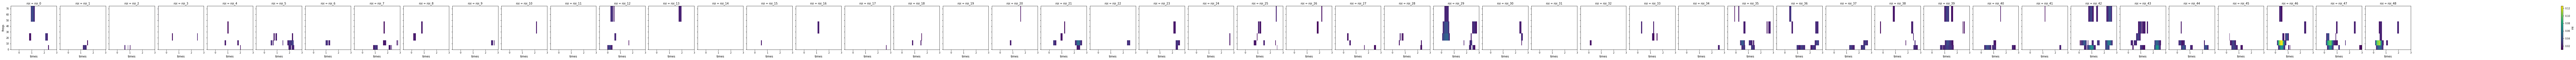

In [258]:
mi_c = mi.copy()
mi_c.data[pvalues.data >= 0.05] = np.nan

mi_c.plot(x='times', y='freqs', col='roi')

Text(0.5, 0, 'time')

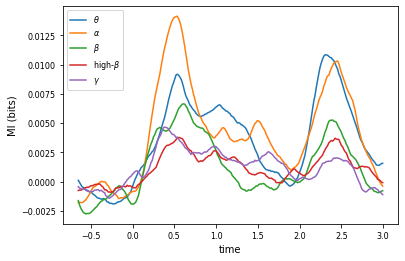

In [270]:
plt.plot(mi_c.times, np.nanmean(mi,-1).T )
plt.legend(band_names)
plt.ylabel("MI (bits)")
plt.xlabel("time")

In [272]:
#### Original data
net = temporal_network(coh_file=f'super_tensor_k_{0.5}_surr_False_morlet.nc', monkey='lucy', 
                       session=1, date='150128', trial_type=[1],
                       behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                       relative=True, verbose=True, q=None, keep_weights=False)

In [275]:
out = net.super_tensor.transpose("trials","roi","freqs","times")

In [276]:
dt = DatasetEphy([out], y=[sxx.attrs["stim"].astype(int)], times="times", roi=None, agg_ch=False)

Definition of an electrophysiological dataset
    Dataset composed of 1 subjects / sessions
WARNING | No regions of interest are provided (roi). Default ones are created
    At least False subjects / roi required
    Supported MI definition I(x; y (discret)) (cd)


In [277]:
mi_type   = 'cd'
inference = 'ffx'
kernel    = np.hanning(1)
wf        = WfMi(mi_type, inference, verbose=True, kernel=kernel)

Gaussian Copula Mutual Information Estimator (mi_type=cd, copnorm=False, biascorrect=True, demeaned=False)
Definition of a non-parametric statistical workflow
Workflow for computing mutual information (ffx - cd)


In [279]:
# list of corrections for multiple comparison
mcps = ['cluster', 'maxstat', 'fdr', 'bonferroni']
kw = dict(n_jobs=20, n_perm=200)
"""
The `cluster_th` input parameter specifies how the threshold is defined.
Use either :
* a float for a manual threshold
* None and it will be infered using the distribution of permutations
* 'tfce' for a TFCE threshold
"""
cluster_th = 'tfce'  # {float, None, 'tfce'}

for mcp in mcps:
    print(f'-> FFX / MCP={mcp}')
    mi, pvalues = wf.fit(dt, mcp=mcp, cluster_th=cluster_th, **kw)

    Evaluate true and permuted mi (n_perm=200, n_jobs=20)


-> FFX / MCP=cluster


  0%|          | Estimating MI : 0/1176 [00:00<?,       ?it/s]

    Fixed-effect inference (FFX)
    Cluster forming threshold (tail=1; alpha=0.05; tfce=True)
    Inference at cluster-level
    Cluster detection (threshold={'start': 0.009388011880218983, 'step': 0.0005502647440880537, 'e_power': 0.5, 'h_power': 2}; tail=1)
    True and permuted mutual-information already computed. Use WfMi.clean to reset arguments
    Fixed-effect inference (FFX)


-> FFX / MCP=maxstat


    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=maxstat; tail=1)
    True and permuted mutual-information already computed. Use WfMi.clean to reset arguments
    Fixed-effect inference (FFX)


-> FFX / MCP=fdr


    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=fdr; tail=1)
    True and permuted mutual-information already computed. Use WfMi.clean to reset arguments
    Fixed-effect inference (FFX)


-> FFX / MCP=bonferroni


    Inference at spatio-temporal level (test-wise)
    Perform correction for MCP (mcp=bonferroni; tail=1)


In [280]:
plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    extent=[pvalues.times.values[0], mi.times.values[-1], 0,22]
    plt.imshow(mi.isel(freqs=i).T, aspect="auto", cmap="jet", origin="lower", vmax=0.04, vmio)
    plt.colorbar()

SyntaxError: positional argument follows keyword argument (<ipython-input-280-c9e315841795>, line 5)

In [ ]:
plt.plot(mi_c.times, np.nanmean(mi,-1).T )
plt.legend(band_names)
plt.ylabel("MI (bits)")
plt.xlabel("time")